# 3D Reconstruction of Cricket

##### Objective: To reconstruct the scene from a video of a cricket bowler

In [136]:
import cv2
import numpy as np
import scipy 

from PIL import Image

from pitch import pitch_map, get_warped_pitch

### Corresponding points

##### Pitch mapping

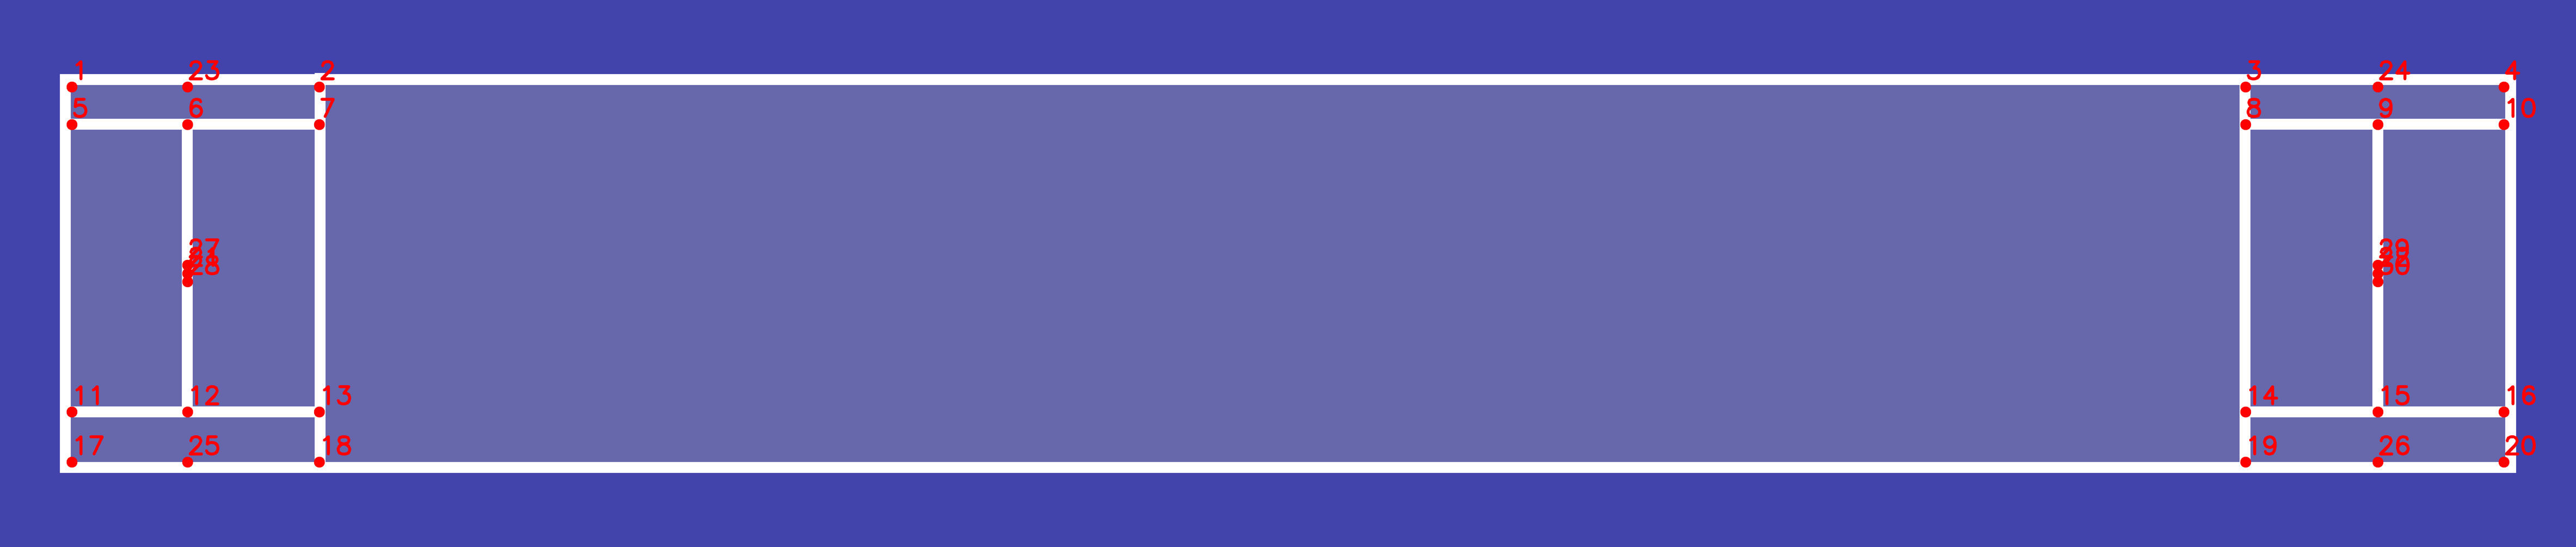

In [141]:
pitch_frame = cv2.imread('pitch.png')

for k, v in pitch_map.items():
    cv2.circle(pitch_frame, (int(v[0] * pitch_frame.shape[1]), int(v[1] * pitch_frame.shape[0])), 20, (255, 0, 0), -1)
    cv2.putText(pitch_frame, str(k), (int(v[0] * pitch_frame.shape[1]), int(v[1] * pitch_frame.shape[0]-30)), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 10)

Image.fromarray(pitch_frame).resize((pitch_frame.shape[1]//2, pitch_frame.shape[0]//2))

##### Images used

(952, 1678, 3)


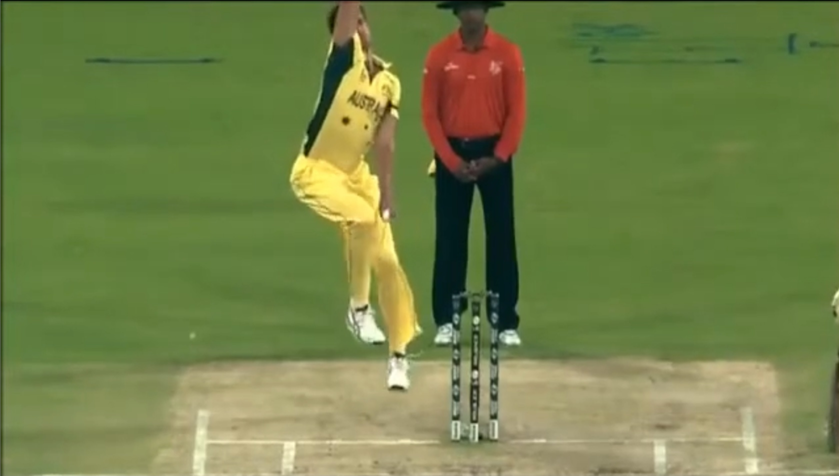

In [142]:
# Front image

front_image = cv2.imread('front_frame.jpg')
front_image = cv2.cvtColor(front_image, cv2.COLOR_BGR2RGB)

print(front_image.shape)
Image.fromarray(front_image).resize((front_image.shape[1]//2, front_image.shape[0]//2))

(952, 1678, 3)


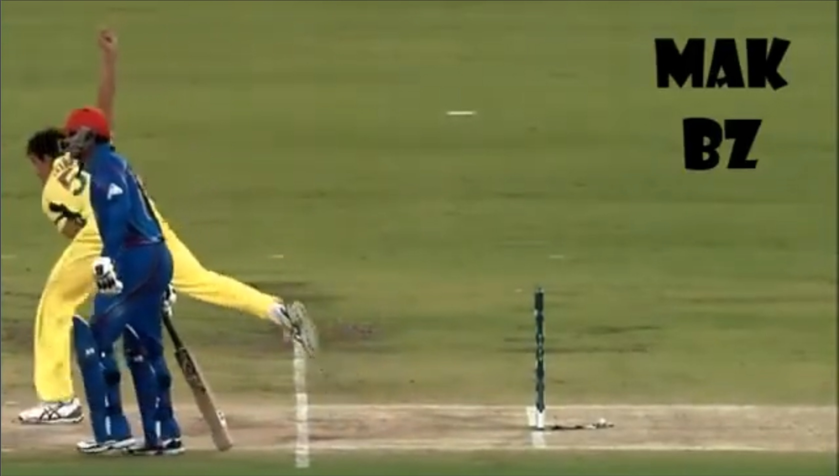

In [143]:
# Side image

side_image = cv2.imread('side_frame.jpg')
side_image = cv2.cvtColor(side_image, cv2.COLOR_BGR2RGB)

print(side_image.shape)
Image.fromarray(side_image).resize((side_image.shape[1]//2, side_image.shape[0]//2))

##### Xw & u

In [152]:
world_map = {
    4: (1.22, 1.83, 0),
    20: (1.22, -1.83, 0),
    24: (0, 1.83, 0),
    26: (0, -1.83, 0),
    "lw0": (.11, 0, 0),
    "lw1": (.11, 0, 71),
    "mw0": (0, 0, 0),
    "mw1": (0, 0, 71),
    "rw0": (-.11, 0, 0),
    "rw1": (-.11, 0, 71),
}

front_map = { # w, h
    4: (422, 820),
    20: (1481, 816),
    24: (415, 883),
    26: (1485, 878),
    "lw0": (911, 881),
    "lw1": (911, 592),
    "mw0": (947, 881),
    "mw1": (952, 592),
    "rw0": (987, 881),
    "rw1": (989, 590),
}

side_map = { 
    4: (1525, 811),
    20: (1563, 897),
    24: (1061, 813),
    26: (1081, 897),
    "lw0": (1070, 853),
    "lw1": (1070, 580),
    "mw0": (1071, 856),
    "mw1": (1071, 583),
    "rw0": (1072, 859),
    "rw1": (1072, 586),
}

world_points = np.array(list(world_map.values()), dtype=np.float32)
front_points = np.array(list(front_map.values()), dtype=np.float32)
side_points = np.array(list(side_map.values()), dtype=np.float32)

#### Pitch homographic overlay

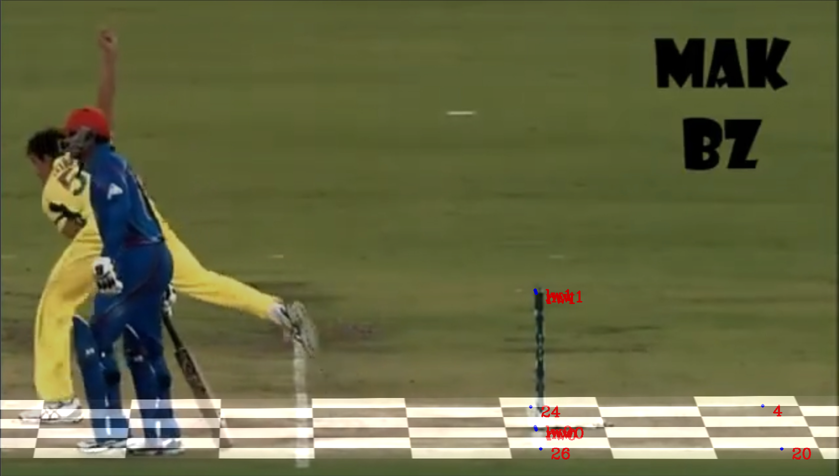

In [147]:
target = side_map

image_path = 'front_frame.jpg' if target == front_map else 'side_frame.jpg'
frame = cv2.imread(image_path)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
h,w = frame.shape[:2]

for k, pt in target.items():
    x, y = pt
    cv2.circle(frame, (x,y), 2, (0,0,255), 2)
    cv2.putText(frame, str(k), (x+20, y+20), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)
    
warped_pitch = get_warped_pitch(image_path, target, pitch='checker')
resized_warped_pitch = cv2.resize(warped_pitch, (w,h))
frame = cv2.addWeighted(frame, 0.8, resized_warped_pitch, 0.5, 0)

# coords = (1071, 580)
# cv2.circle(frame, coords, 2, (255,0,0), -1)

Image.fromarray(frame).resize((w//2, h//2))

### Camera Matrices

##### Nayar

In [254]:
h, w = (952, 1678)

def compute_A(world_points, image_points):
    A = []
    common_keys = sorted(set(world_points.keys()) & set(image_points.keys()), key=lambda x: str(x))
    for key in common_keys:
        X, Y, Z = world_points[key]
        u, v = image_points[key]
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u * X, -u * Y, -u * Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v * X, -v * Y, -v * Z, -v])
    return np.array(A)

def compute_projection_matrix(world_points, image_points):
    A = compute_A(world_points, image_points)
    # print(A)
    _, _, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)
    P /= P[-1, -1]
    return P

P1 = compute_projection_matrix(world_map, front_map)
P2 = compute_projection_matrix(world_map, side_map)

def decompose_P(p):
    K, R = np.linalg.qr(np.linalg.inv(p[:, :3]))

    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R

    K /= K[2,2]
    
    t = np.linalg.inv(K) @ p[:,3]
    return K, R, t

K1, R1, t1 = decompose_P(P1)
K2, R2, t2 = decompose_P(P2)

C1 = -np.linalg.inv(R1) @ t1
C2 = -np.linalg.inv(R2) @ t2

C1_H = np.append(C1, 1)
C2_H = np.append(C2, 1)

Rt1 = np.hstack((R1.T, t1.reshape(-1, 1)))
Rt1 = np.vstack((Rt1, np.array([0,0,0,1])))

Rt2 = np.hstack((R2.T, t2.reshape(-1, 1)))
Rt2 = np.vstack((Rt2, np.array([0,0,0,1])))

P_prime1 = Rt1 @ C1_H
P_prime2 = Rt2 @ C2_H

print("Front P:\n", P1)
print("Side P:\n", P2)
print("--------------")
print(
    "Front values:\n",
    "K:\n", K1, "\n",
    "R:\n", R1, "\n",
    "t:\n", t1, "\n",
    "\nSide values:\n",
    "K:\n", K2, "\n",
    "R:\n", R2, "\n",
    "t:\n", t2, "\n",
)
print("----------------")
print("front camera:", C1)
print("side camera:", C2)
print("-----------------")
print("front P_prime:", P_prime1)
print("side P_prime:", P_prime2)


Front P:
 [[ 4.58143761e+00 -2.88597892e+02 -1.32663300e+01  9.49058248e+02]
 [-4.32349457e+01  4.69978241e+00 -1.23416794e+01  8.80722618e+02]
 [ 9.01956887e-03  4.07849928e-03 -1.39782107e-02  1.00000000e+00]]
Side P:
 [[-8.27184579e+02 -1.67260163e+01  8.99370379e+01  1.07172503e+03]
 [-6.72546428e+02 -2.09644559e+01  4.51168582e+01  8.56209221e+02]
 [-7.86011831e-01 -1.05390777e-02  8.39835987e-02  1.00000000e+00]]
--------------
Front values:
 K:
 [[ 0.02514397 -1.04139364 -0.64525919]
 [ 1.17160019  0.20907511 -0.29177549]
 [ 0.3580686  -0.61096582  1.        ]] 
 R:
 [[-3.57499946e-03 -3.80579233e-03 -1.41519877e+01]
 [ 0.00000000e+00  2.28834743e-02  1.54657154e+01]
 [ 0.00000000e+00  0.00000000e+00 -5.83830601e+01]] 
 t:
 [ 703.3508683  -536.01139414 -578.33249917] 
 
Side values:
 K:
 [[ 0.52465404  0.86051485 -9.3591111 ]
 [-8.58127202  3.86713475 -0.12548971]
 [ 3.83343409  8.53893971  1.        ]] 
 R:
 [[ 1.73315993e-01 -5.37791927e-03 -1.77863929e+02]
 [ 0.00000000e+00 -

##### OpenCV + Nayar

In [255]:
K1 = cv2.initCameraMatrix2D([world_points], [front_points], (w, h))
K2 = cv2.initCameraMatrix2D([world_points], [side_points], (w, h))

def compute_projection_matrix(world_points, image_points):
    A = compute_A(world_points, image_points)
    # print(A)
    _, _, Vt = np.linalg.svd(A)
    P = Vt[-1].reshape(3, 4)
    return P

P1 = compute_projection_matrix(world_map, front_map)
P2 = compute_projection_matrix(world_map, side_map)

KR1 = P1[:,:3]
KR2 = P2[:,:3]
Kt1 = P1[:,3]
Kt2 = P2[:,3]

R1 = np.linalg.inv(K1) @ KR1
R2 = np.linalg.inv(K2) @ KR2

t1 = np.linalg.inv(K1) @ Kt1
t2 = np.linalg.inv(K2) @ Kt2

C1 = np.linalg.inv(R1.T) @ t1
C2 = np.linalg.inv(R2.T) @ t2

C1_H = np.append(C1, 1)
C2_H = np.append(C2, 1)

Rt1 = np.hstack((R1.T, t1.reshape(-1, 1)))
Rt1 = np.vstack((Rt1, np.array([0,0,0,1])))

Rt2 = np.hstack((R2.T, t2.reshape(-1, 1)))
Rt2 = np.vstack((Rt2, np.array([0,0,0,1])))

P_prime1 = Rt1 @ C1_H
P_prime2 = Rt2 @ C2_H

print("front camera matrix (K1):\n", K1, '\n')
print("side camera matrix (K2):\n", K2)
print('-------------------------')
print("Front P:\n", P1, '\n')
print("Side P:\n", P2)
print('-------------------------')
print("Front Camera:\n", "R:-----\n", R1, '\n', 't:-----\n', t1, '\n')
print("Side Camera:\n", "R:-----\n", R2, '\n', 't:-----\n', t2, '\n')
print('-------------------------')
print("Front Camera:", C1)
print("Side Camera:", C2)
print('-------------------------')
print("front P_prime:", P_prime1)
print("side P_prime:", P_prime2)

front camera matrix (K1):
 [[8.48094112e+03 0.00000000e+00 8.38500000e+02]
 [0.00000000e+00 8.48094112e+03 4.75500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

side camera matrix (K2):
 [[1.73050192e+03 0.00000000e+00 8.38500000e+02]
 [0.00000000e+00 1.73050192e+03 4.75500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
-------------------------
Front P:
 [[ 3.45151201e-03 -2.17420639e-01 -9.99443871e-03  7.14990843e-01]
 [-3.25718578e-02  3.54066928e-03 -9.29783584e-03  6.63508914e-01]
 [ 6.79506149e-06  3.07261398e-06 -1.05307474e-05  7.53368768e-04]] 

Side P:
 [[-4.75276743e-01 -9.61029344e-03  5.16752652e-02  6.15782736e-01]
 [-3.86426058e-01 -1.20455803e-02  2.59228641e-02  4.91953477e-01]
 [-4.51620053e-04 -6.05545442e-06  4.82545883e-05  5.74571571e-04]]
-------------------------
Front Camera:
 R:-----
 [[-2.64846439e-07 -2.59401666e-05 -1.37296911e-07]
 [-4.22157270e-06  2.45213510e-07 -5.05894970e-07]
 [ 6.79506149e-06  3.07261398e-06 -1.05307474e-05]] 

#### OpenCV

In [258]:
Ki1 = cv2.initCameraMatrix2D([world_points], [front_points], (w, h))
Ki2 = cv2.initCameraMatrix2D([world_points], [side_points], (w, h))

_, K1, d1, Rv1, tv1 = cv2.calibrateCamera(
    [world_points],
    [front_points],
    (w, h),
    Ki1,
    None,
    flags=cv2.CALIB_USE_INTRINSIC_GUESS
)
_, K2, d2, Rv2, tv2 = cv2.calibrateCamera(
    [world_points],
    [side_points],
    (w, h),
    Ki2,
    None,
    flags=cv2.CALIB_USE_INTRINSIC_GUESS
)

R1, _ = cv2.Rodrigues(Rv1[0])
R2, _ = cv2.Rodrigues(Rv2[0])

C1 = -np.linalg.inv(R1) @ t1
C2 = -np.linalg.inv(R2) @ t2

print("front camera matrix (K1):\n", Ki1, '\n')
print("side camera matrix (K2):\n", Ki2, '\n')
print("OpenCV Calibration Values:\n----------------------------------")
print("front:\n -K:\n", K1, "\n-R:\n", R1, "\n-T:\n", t1)
print("side:\n -K:\n", K2, "\n-R:\n", R2, "\n-T:\n", t2)
print("OpenCV Camera Positions:\n----------------------------------")
print("front camera:", C1)
print("side camera:", C2)

front camera matrix (K1):
 [[5.41470397e+03 0.00000000e+00 2.83784846e+02]
 [0.00000000e+00 5.80889498e+02 7.07092980e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

side camera matrix (K2):
 [[3.59990807e+03 0.00000000e+00 4.79587642e+02]
 [0.00000000e+00 3.01959238e+02 7.82694771e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

OpenCV Calibration Values:
----------------------------------
front:
 -K:
 [[5.41470397e+03 0.00000000e+00 2.83784846e+02]
 [0.00000000e+00 5.80889498e+02 7.07092980e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
-R:
 [[-0.05282564 -0.99544076 -0.07941752]
 [-0.99645216  0.05776266 -0.06120923]
 [ 0.06551753  0.07590234 -0.99496045]] 
-T:
 [9.82097737e-06 3.59962486e-05 7.53368768e-04]
side:
 -K:
 [[3.59990807e+03 0.00000000e+00 4.79587642e+02]
 [0.00000000e+00 3.01959238e+02 7.82694771e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
-R:
 [[-0.99577336  0.03043497 -0.08665526]
 [-0.00954245  0.90410936  0.42719458]
 [ 0.09134748  